# DBSCAN Analaysis

In [2]:
import os
import sys
from pathlib import Path

In [ ]:
# use Path(os.getcwd()) outside the vscode to get the root folder

# Root Folder - use hardcode in vscode jupyter notebook, due to kernel inconsistency
ROOT_DIR = "d:/Desktop/Data Science Learning/DS Self Projects/IITG Capstone/Stock Market Anomaly Detection/stock-anomaly-detector/"
project_root = ROOT_DIR

# selecing the root as working directory
os.chdir(project_root)


# Adding the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root) 

## Data Loading 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [36]:
DATA_DIR = Path("data/processed")

# loading features.csv
df_features = pd.read_csv(DATA_DIR / "features.csv", parse_dates=["date"])

df_features.head()

,date,ticker,ret,ret_z,vol_z,range_pct
0,1999-03-10,QQQ,NaN,NaN,NaN,NaN
1,1999-03-11,QQQ,0.004896,NaN,NaN,NaN
2,1999-03-12,QQQ,-0.024361,NaN,NaN,NaN
3,1999-03-15,QQQ,0.028714,NaN,NaN,NaN
4,1999-03-16,QQQ,0.008495,NaN,NaN,NaN


In [39]:
# loading rule_based anomaly data
df_rule_test = pd.read_csv(
    DATA_DIR / "anomalies_rule_test.csv",
    parse_dates=["date"]
)

df_rule_test.head()

,date,ticker,anomaly_flag,type,ret,ret_z,vol_z,range_pct,why
0,2020-01-06,NaN,1,NaN,0.006443,0.623673,0.319200,0.984127,range_pct > 0.95
1,2020-01-24,NaN,1,NaN,-0.008415,-1.958409,1.901769,1.000000,range_pct > 0.95
2,2020-01-27,NaN,1,crash,-0.020656,-3.994795,2.072816,0.809524,|ret_z| > 2.5
3,2020-01-31,NaN,1,crash+ volume_shock,-0.015858,-2.815644,3.118565,1.000000,|ret_z| > 2.5; vol_z > 2.5; range_pct > 0.95
4,2020-02-04,NaN,1,spike,0.022889,3.008675,0.543106,0.936508,|ret_z| > 2.5


In [40]:
# loading K-Means anomaly data

df_kmeans_test = pd.read_csv(
    DATA_DIR / "anomalies_kmeans_test.csv",
    parse_dates=["date"]
)

df_kmeans_test.head()

,date,ticker,anomaly_flag,cluster,distance
0,2020-02-24,QQQ,1,0,3.193727
1,2020-02-27,QQQ,1,0,3.030025
2,2020-03-02,QQQ,1,1,2.995849
3,2020-03-13,QQQ,1,1,2.503699
4,2020-03-16,QQQ,1,0,2.736320


## Build Feature Matrix and Meta

In [32]:
# few utility functions are detector agnostic, imported below from K-Means
# we are not using any k-means related methods in DBSCAN 
from src.detectors.kmeans import build_feature_matrix  
from src.detectors.kmeans import split_by_date
from src.detectors.kmeans import scale_features

# build feature matrix X and meta for DBSCAN
X, meta = build_feature_matrix(df_features)

# now we split the feature set using meta that has date
# splitting is as follows
# - Train set from year 2018
# - Val set from year 2019
# - Test set from 2020
X_train, X_val, X_test, meta_train, meta_val, meta_test = split_by_date(X, meta)


# we need to scale the features for DBSCAN as well
scaler, X_train_s, X_val_s, X_test_s = scale_features(X_train, X_val, X_test)



## DBSCAN for choosing eps

In [ ]:
from sklearn.neighbors import NearestNeighbors

[[0.         0.17727348 0.35811506 ... 0.37147429 0.40542328 0.41016607]
 [0.         0.09596527 0.10084674 ... 0.17423929 0.17652595 0.18217292]
 [0.         0.10033005 0.12328023 ... 0.16173471 0.18328203 0.19979102]
 ...
 [0.         0.08310844 0.0843322  ... 0.13246167 0.14809897 0.18619266]
 [0.         0.12016384 0.12941149 ... 0.13379744 0.14386276 0.15843133]
 [0.         0.06808177 0.09434547 ... 0.16828803 0.16928724 0.19708968]]


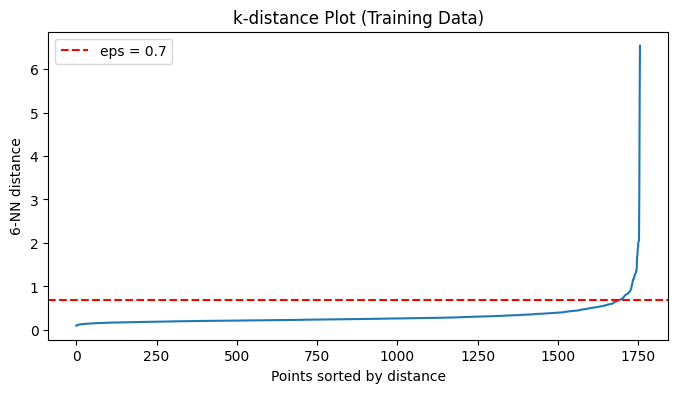

In [27]:
# using training data
X_dbscan_train = X_train_s

# min_samples heuristic
min_sample = 7 # 2 * number_of_features(3) + 1 : ret_z, vol_z, range_pct

# fit NearestNeighbors
nn = NearestNeighbors(n_neighbors=min_sample)
nn.fit(X_dbscan_train)

# distance to k-th nearest neighbor
distances, _ = nn.kneighbors(X_dbscan_train)

print(distances)

# take the k-th distance
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.axhline(y=0.7, color="red", linestyle="--", label="eps = 0.7")
plt.xlabel("Points sorted by distance")
plt.ylabel("6-NN distance")
plt.title("k-distance Plot (Training Data)")
plt.legend()
plt.show()


#### Conclusion

- chosen $\epsilon$ = 0.7

- chosen $min\_sample$ = 7

## Training DBSCAN

In [14]:
from src.detectors.dbscan import fit_dbscan, detect_dbscan_anomaly

In [28]:
# frozen values to be used throughout 

eps = 0.7 # as per knee plot
min_samples = 7 # 2 * 3(ret_z, vol_z, range_pct) + 1

In [34]:

# DBSCAN fit on scaled Training Set
dbscan_train = fit_dbscan(X_train_s, eps, min_samples)

# we take out labels to pick the noise points
train_labels = dbscan_train.labels_

# anomaly detection
df_dbscan_train = detect_dbscan_anomaly(train_labels, meta_train)

# % noise in training
train_noise_rate = len(df_dbscan_train) / len(meta_train)
print(f"Noise Rate (Train Set): {train_noise_rate*100:.2f}%")


Noise Rate (Train Set): 1.59%


### Validation (Walk forward/Expanding window)

Note: DBSCAN is stateless, means it doesn't learn anything from the given set. It simply works on the set and create labels, where -1 is for Noise points (anomalies in our case). So in expanding window, we need to refit DBSCAN and then check the flag rate on only Val set labels.

In [31]:
from sklearn.cluster import DBSCAN

# Refitting DBSCAN on Expanded window with TRAIN+VAL set

train_plus_val_set = np.vstack([X_train_s, X_val_s])

train_plus_val_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(train_plus_val_set)

val_labels = train_plus_val_labels[len(X_train_s):]

# anomaly detection in val_labels
df_dbscan_val = detect_dbscan_anomaly(val_labels, meta_val)

# flag rate
val_noise_rate = len(df_dbscan_val) / len(meta_val)
print(f'Noise Rate (Val set): {val_noise_rate*100:.2f}%')

Noise Rate (Val set): 1.19%


### Test (Expanding window)

Fit on TRAIN + VAL, score TEST 

In [35]:
# combining window from X_train to X_val
X_ref = np.vstack([X_train_s, X_val_s])

# expanding the window to X_test 
train_val_plus_test_set = np.vstack([X_ref, X_test_s])

# refitting on whole expanded window 
labels_ref_plus_test = DBSCAN(eps=eps, min_samples=7).fit_predict(train_val_plus_test_set)

# extracting test_labels
test_labels = labels_ref_plus_test[len(X_ref) :]

# detecting anamoly in the labels
df_dbscan_test = detect_dbscan_anomaly(test_labels, meta_test)

# flag rate
val_noise_rate = len(df_dbscan_test) / len(meta_test)
print(f'Noise Rate (Val set): {val_noise_rate*100:.2f}%')

# persist the results of dbscan test anomaly
df_dbscan_test.to_csv(Path("data/processed/anomalies_dbscan_test.csv"), index=False)

Noise Rate (Val set): 1.84%


### Conclusion

For test evaluation, DBSCAN was refit on an expanding window consisting of the training and validation data, and then applied to the test period. This ensures that density structure is learned strictly from historical data. Under this setup, DBSCAN flagged approximately 1.8% of ticker-day points during the 2020 Q1 period, reflecting a conservative but responsive detection of structural outliers

## Comparison Plots

### Plot 1: Data-Level Anomaly Overlap (bar chat)

This will show, 

How many days did each detector flag at least one anomaly?

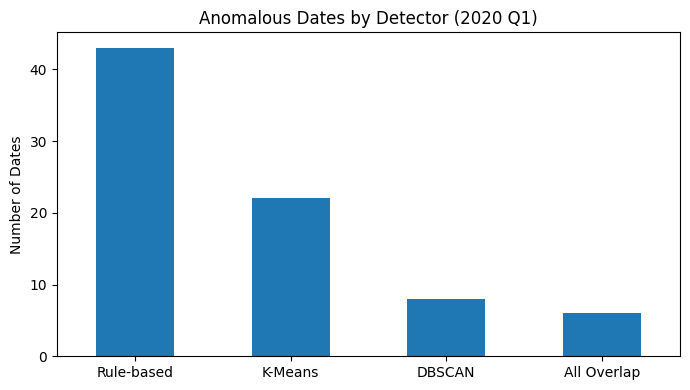

In [42]:
# unique anomaly dates
rule_dates   = set(df_rule_test["date"])
kmeans_dates = set(df_kmeans_test["date"])
dbscan_dates = set(df_dbscan_test["date"])

overlap = rule_dates & kmeans_dates & dbscan_dates

counts = {
    "Rule-based": len(rule_dates),
    "K-Means": len(kmeans_dates),
    "DBSCAN": len(dbscan_dates),
    "All Overlap": len(overlap)
}

pd.Series(counts).plot(
    kind="bar",
    figsize=(7,4),
    title="Anomalous Dates by Detector (2020 Q1)"
)

plt.ylabel("Number of Dates")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("reports/figures/rule_vs_kmeans_vs_dbscan.png")
plt.show()

print()

### Plot 2: Daily anomaly counts over time (timeline)

Plot shows detectors' reactivity during crisis

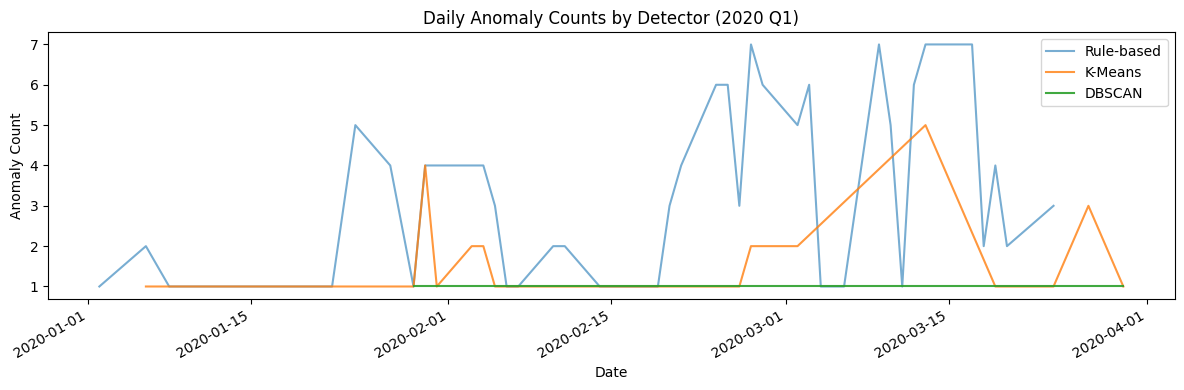

In [45]:
rule_daily = df_rule_test.groupby('date').size()
kmeans_daily = df_kmeans_test.groupby('date').size()
dbscan_daily = df_dbscan_test.groupby('date').size()

plt.figure(figsize=(12,4))
rule_daily.plot(label="Rule-based", alpha=0.6)
kmeans_daily.plot(label="K-Means", alpha=0.8)
dbscan_daily.plot(label="DBSCAN", alpha=0.9)

plt.title("Daily Anomaly Counts by Detector (2020 Q1)")
plt.xlabel("Date")
plt.ylabel("Anomaly Count")
plt.legend()
plt.tight_layout()
plt.savefig("reports/figures/daily_anomaly_count.png")
plt.show()

### Plot 3: Point-level flag rates (bar chart)

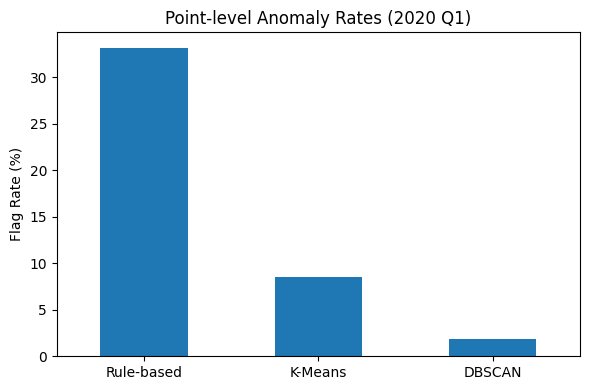

In [46]:
rates = {
    "Rule-based": len(df_rule_test) / len(meta_test),
    "K-Means": len(df_kmeans_test) / len(meta_test),
    "DBSCAN": len(df_dbscan_test) / len(meta_test),
}

pd.Series(rates).mul(100).plot(
    kind="bar",
    figsize=(6, 4),
    title="Point-level Anomaly Rates (2020 Q1)"
)

plt.ylabel("Flag Rate (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("reports/figures/flag_rate.png")
plt.show()
